# Isprobavanje mogućih datasetova




In [1]:
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, utils, models
from PIL import Image
from torchvision.transforms.functional import pad, resize, to_tensor, to_grayscale
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import time
import copy

In [2]:
# Access to uploaded files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_prefix = 'drive/My Drive/Colab Notebooks/Diplomski'

In [4]:
class TeethDataset(Dataset):
  """Face Landmarks dataset."""
  def __init__(self, df, calc_label, photo_dir, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.tooth_dframe = df
    self.calc_label = calc_label
    self.photo_dir = photo_dir
    self.transform = transform

    #extracting image name
    self.tooth_dframe['img_name'] = self.tooth_dframe['image_identifier'] + "_" + self.tooth_dframe['image_md5'] + ".jpg"

    #creating column for id uniquely identifying a tooth on a single x-ray
    self.tooth_dframe['tooth_id'] = self.tooth_dframe['sex'] + "_" + self.tooth_dframe['quad'].apply(str) + "_" + self.tooth_dframe['index'].apply(str)
    
    self.tooth_dframe['center_x'] = (self.tooth_dframe['x1'] + self.tooth_dframe['x2'])/2
    self.tooth_dframe['center_y'] = (self.tooth_dframe['y1'] + self.tooth_dframe['y2'])/2
    self.tooth_dframe['width'] = abs(self.tooth_dframe['x1'] - self.tooth_dframe['x2'])
    self.tooth_dframe['height'] = abs(self.tooth_dframe['y1'] - self.tooth_dframe['y2'])
    if self.calc_label != None:
      self.tooth_dframe['label'] = self.calc_label(self.tooth_dframe)
  
  def get_pandas_row(self, idx):
    return self.tooth_dframe.iloc[idx]
    
  def __len__(self):
    return len(self.tooth_dframe)

  def __getitem__(self, idx):
    # Don't really understand what's this for
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.photo_dir,
                            self.tooth_dframe.iloc[idx]['img_name'])
    image = Image.open(img_name)
    info = self.tooth_dframe.iloc[idx]
    sample = {'image': image, 'info': info, 'idx': torch.tensor(idx)}

    if self.transform:
        sample = self.transform(sample)

    return sample

In [5]:
class SquarePad(object):
  """Padds PIL image to be of square dimensions"""
  
  def __call__(self, sample):
    w, h = sample['image'].size
    max_wh = np.max([w, h])
    left_right_p = int((max_wh - w) / 2)
    top_bttm_p = int((max_wh - h) / 2)
    padding = (left_right_p, top_bttm_p)
    sample['image'] = pad(sample['image'], padding, fill=0, padding_mode='constant')
    return sample
  
class CropOutTooth(object):
  """Crops out tooth from its bounding box, or expanded bounding box by the specified coeficient"""
  def __init__(self, expand_bbox_by=0.0):
    self.coef = expand_bbox_by
  
  def __call__(self, sample):
    image, d = sample['image'], sample['info']
    
    w, h = image.size
    bbox_w = d['x2'] - d['x1']
    bbox_h = d['y2'] - d['y1']
    x1 = d['x1'] - int((bbox_w * self.coef)/2)
    x2 = d['x2'] + int((bbox_w * self.coef)/2)
    y1 = d['y1'] -  int((bbox_h * self.coef)/2)
    y2 = d['y2'] + int((bbox_h * self.coef)/2)
    if x1 < 0: x1 = 0
    if y1 < 0: y1 = 0
    if x2 > w: x2 = w
    if y2 > h: y2 = h
    
    sample['image'] = image.crop((x1, y1, x2, y2))
    return sample
  
class ResizeImg(object):
  """Resizes final image to desired size"""
  def __init__(self, img_size):
    assert isinstance(img_size, (list, tuple))
    self.img_size = img_size
  
  def __call__(self, sample):
    sample['image'] = resize(sample['image'], self.img_size)
    return sample

class ImgTrans(object):
  """Transforms image and desn't touch info"""
  def __init__(self, transf):
    self.t = transf
  
  def __call__(self, sample):
    sample['image'] = self.t(sample['image'])
    return sample

class InfoTrans(object):
  """Transforms info and desn't touch image"""
  def __init__(self, transf):
    self.t = transf
  
  def __call__(self, sample):
    sample['info'] = self.t(sample['info'])
    return sample

In [9]:
# Loading teeth info
csv_file = f"{dir_prefix}/teeth_info/all_pertooth_annotations_202110.csv"
photo_dir = f'{dir_prefix}/data_store'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_column', None)
pd.set_option("display.max_rows", None)
image_size = (224, 224)

In [10]:
# Helper functions
def bridge_label(info):
  return (info['bridge'] == 'yes') * 1

def yesno_label(info, lbl):
  return (info[lbl] == 'yes') * 1

def label_tensor(info):
  return torch.tensor(info['label'])

# For binary classification, indended to create img datasets
# for ImageFolder class
def save_datasetimgs(dataset, dir, attr):
  i = 0
  print(f'Saving to: {dir}')
  for sample in dataset:
    row = dataset.get_pandas_row(int(sample['idx']))
    image_name = os.path.splitext(row['img_name'])[0] + '--' + row['tooth_id'] + '.jpg'
    class_folder = row[attr]
    sample['image'].save(f'{dir}/{class_folder}/{image_name}', 'JPEG')
    i += 1
    if i % 30 == 0: print(f'{i}/{len(dataset)} done.')
  print()

# For multi label classification
def save_multilabel_img_dataset(df, dir):
  dataset = TeethDataset(df=df, 
                         calc_label=None,
                         photo_dir=photo_dir, 
                         transform=transforms.Compose([
                                          CropOutTooth(expand_bbox_by=0.2),
                                          SquarePad(),
                                          ResizeImg(image_size)
                                          ]))
  
  multi_label_dataset_img_dir = os.path.join(dir, 'img')
  os.makedirs(multi_label_dataset_img_dir)

  df.to_csv(os.path.join(dir, 'tooth_info.csv'), sep=';', index=False)

  i = 0
  print(f'Saving to: {multi_label_dataset_img_dir}')
  for sample in dataset:
    row = dataset.get_pandas_row(int(sample['idx']))
    image_name = os.path.splitext(row['img_name'])[0] + '--' + row['tooth_id'] + '.jpg'
    sample['image'].save(f'{multi_label_dataset_img_dir}/{image_name}', 'JPEG')
    i += 1
    if i % 200 == 0: print(f'{i}/{len(dataset)} done.')
  print()

## Creation of different binary datasets for ImageFolder class

In [ ]:
df = pd.read_csv(csv_file, sep = ";")

#attrs = ['missing', 'crown', 'endofilling']
attrs = ['filling']

for attr in attrs:
  print(attr)
  yes = df[df[attr] == 'yes'].copy()
  num_with_yes = len(yes)
  no = df[df[attr] == 'no'].sample(n=num_with_yes).copy()
  no_total = 2*num_with_yes


  yes_train, yes_val = train_test_split(yes, test_size=0.3)
  no_train, no_val = train_test_split(no, test_size=0.3)


  df_train = pd.concat([yes_train, no_train])
  df_val = pd.concat([yes_val, no_val])
  print(f'len(df_train): {len(df_train)}')
  print(f'len(df_val): {len(df_val)}')
  print()

  teeth_dataset_train = TeethDataset(df=df_train, 
                                    calc_label=lambda x: yesno_label(x, attr),
                                    photo_dir=photo_dir, 
                                    transform=transforms.Compose([
                                                            CropOutTooth(expand_bbox_by=0.2),
                                                            SquarePad(),
                                                            ResizeImg(image_size),
                                                            #ImgTrans(to_tensor),
                                                            InfoTrans(label_tensor)
                                                            ]))

  teeth_dataset_val = TeethDataset(df=df_val,
                                  calc_label=lambda x: yesno_label(x, attr),
                                  photo_dir=photo_dir, 
                                  transform=transforms.Compose([
                                                            CropOutTooth(expand_bbox_by=0.2),
                                                            SquarePad(),
                                                            ResizeImg(image_size),
                                                            #ImgTrans(to_tensor),
                                                            InfoTrans(label_tensor)
                                                            ]))

  save_datasetimgs(teeth_dataset_val, f'{dir_prefix}/{attr}_dataset/val', attr)
  save_datasetimgs(teeth_dataset_train, f'{dir_prefix}/{attr}_dataset/train', attr)
  print()

## Creation of a single multilabel dataset with 'bridge', 'endofilling', 'filling', 'crown'

In [11]:
most_interesting_cols = ['bridge', 'endofilling', 'filling', 'crown']
df = pd.read_csv(csv_file, sep = ";")
sets_of_indexes = {x: (df[x] == 'yes') | (df[x] == 'no') for x in most_interesting_cols}
mask_of_interest = sets_of_indexes['bridge']
for x in most_interesting_cols: mask_of_interest = mask_of_interest | sets_of_indexes[x]

print('Sanity check that all of these attributes have the same set of annotated indexes:')
all_same_indexes = True
for x in most_interesting_cols:
  if not (mask_of_interest == sets_of_indexes[x]).all(): all_same_indexes = False
if not all_same_indexes:
  print('they don\'t have the same set of annotated indexes\n')
else:
  print('they have the same set of annotated indexes\n')


multi_df = df[mask_of_interest].copy()
#multi_df_subset = multi_df.sample(n=400).copy()

multi_label_dataset_dir = os.path.join(dir_prefix, 'multi_label_dataset')

save_multilabel_img_dataset(multi_df, multi_label_dataset_dir)

Sanity check that all of these attributes have the same set of annotated indexes:
they have the same set of annotated indexes

Saving to: drive/My Drive/Colab Notebooks/Diplomski/multi_label_dataset/img
200/29699 done.
400/29699 done.
600/29699 done.
800/29699 done.
1000/29699 done.
1200/29699 done.
1400/29699 done.
1600/29699 done.
1800/29699 done.
2000/29699 done.
2200/29699 done.
2400/29699 done.
2600/29699 done.
2800/29699 done.
3000/29699 done.
3200/29699 done.
3400/29699 done.
3600/29699 done.
3800/29699 done.
4000/29699 done.
4200/29699 done.
4400/29699 done.
4600/29699 done.
4800/29699 done.
5000/29699 done.
5200/29699 done.
5400/29699 done.
5600/29699 done.
5800/29699 done.
6000/29699 done.
6200/29699 done.
6400/29699 done.
6600/29699 done.
6800/29699 done.
7000/29699 done.
7200/29699 done.
7400/29699 done.
7600/29699 done.
7800/29699 done.
8000/29699 done.
8200/29699 done.
8400/29699 done.
8600/29699 done.
8800/29699 done.
9000/29699 done.
9200/29699 done.
9400/29699 done.
96

## Some image visualizations

lbl: 1


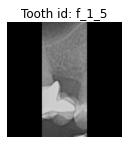

lbl: 1


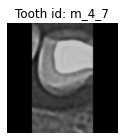

lbl: 0


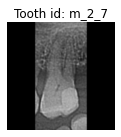

lbl: 0


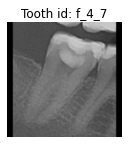

lbl: 0


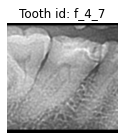

In [ ]:
fig = plt.figure()
#for i in range(len(teeth_dataset_train)):
for j,i in enumerate([1,2,500,600,700]):
  sample = teeth_dataset_train[i]
  row = teeth_dataset_train.get_pandas_row(int(sample['idx']))
  ax = plt.subplot(2, 3, j + 1)
  plt.tight_layout()
  print(f"lbl: {sample['info']}")
  ax.set_title(f"Tooth id: {row['tooth_id']}")
  ax.axis('off')
  plt.imshow(sample['image'])
  #plt.imshow(transforms.ToPILImage()(sample['image'])) #interpolation="bicubic" ??
  plt.pause(0.001)
  if i == 5: break
plt.show()

In [ ]:
datasets = {'train': teeth_dataset_train, 'val': teeth_dataset_val}
dataloaders = {x: DataLoader(datasets[x], batch_size=4,
                             shuffle=True, num_workers=2, prefetch_factor=8, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = ['no', 'yes']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("cuda:0" if torch.cuda.is_available() else "cpu")

cuda:0


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch['image']
                labels = batch['info']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

# Saving the model
# torch.save(model_ft, f'{dir_prefix}/model')
# the_model = torch.load(f'{dir_prefix}/model')

Epoch 0/0
----------
train Loss: 0.4492 Acc: 0.8053
val Loss: 0.3181 Acc: 0.8766

Training complete in 2m 12s
Best val Acc: 0.876623


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, batch in enumerate(dataloaders['val']):
            inputs = batch['image']
            labels = batch['info']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                #plt.imshow(inputs.cpu().data[j])
                plt.imshow(transforms.ToPILImage()(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

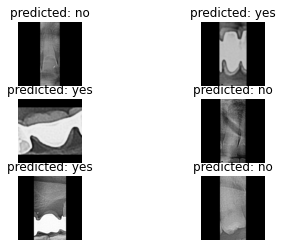

In [ ]:
visualize_model(model_ft)